# **Setup**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Date & time
from datetime import datetime
import calendar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.ticker as mticker

# Statistics & analysis
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Utilities
from itertools import combinations

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

In [ ]:
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

# **Data Loading**

In [ ]:
df = pd.read_csv('tabel_analisa_kimia_farma.csv')
print(f"Total rows: {len(df)}")
display(df.head())

Total rows: 672458


,transaction_id,date,branch_id,branch_name,kota,provinsi,rating_cabang,customer_name,product_id,product_name,actual_price,discount_percentage,persentase_gross_laba,nett_sales,nett_profit,rating_transaksi
0,TRX5844188,9/7/2023,88605,Kimia Farma - Klinik & Apotek,Sukabumi,Jawa Barat,4.7,Elizabeth Thomas,KF260,"Other analgesics and antipyretics, Pyrazolones...",118700,0.05,0.2,112765.0,22553.0,3.0
1,TRX6182886,11/7/2022,27840,Kimia Farma - Apotek,Denpasar,Bali,4.3,Andrew Martinez,KF492,"Psycholeptics drugs, Hypnotics and sedatives d...",751900,0.07,0.3,699267.0,209780.1,4.8
2,TRX7691180,5/30/2023,62913,Kimia Farma - Apotek,Palembang,Sumatera Selatan,4.5,Charles Reynolds,KF540,"Other analgesics and antipyretics, Salicylic a...",744200,0.03,0.3,721874.0,216562.2,3.3
3,TRX3205743,11/28/2022,31604,Kimia Farma - Apotek,Pontianak,Kalimantan Barat,4.4,Casey Cochran,KF389,Drugs for obstructive airway diseases,761700,0.06,0.3,715998.0,214799.4,3.5
4,TRX3644533,5/28/2023,20322,Kimia Farma - Klinik-Apotek-Laboratorium,Subang,Jawa Barat,4.1,Rebecca Moore,KF854,Drugs for obstructive airway diseases,681000,0.13,0.3,592470.0,177741.0,4.1


In [ ]:
print(f"Total Transaksi: {len(df):,}")
print(f"Total Nett Sales: Rp {df['nett_sales'].sum():,.2f}")
print(f"Total Nett Profit: Rp {df['nett_profit'].sum():,.2f}")
print(f"Rata-rata Rating Transaksi: {df['rating_transaksi'].mean():.2f}")
print(f"Rata-rata Rating Cabang: {df['rating_cabang'].mean():.2f}")

Total Transaksi: 672,458
Total Nett Sales: Rp 321,171,190,319.00
Total Nett Profit: Rp 91,214,988,059.85
Rata-rata Rating Transaksi: 4.00
Rata-rata Rating Cabang: 4.45


In [ ]:
name_map = {
    'Other analgesics and antipyretics, Pyrazolones and Anilides': 'Analgesic/Antipyretic (Pyrazolones & Anilides)',
    'Psycholeptics drugs, Hypnotics and sedatives drugs': 'Psycholeptics (Hypnotics/Sedatives)',
    'Other analgesics and antipyretics, Salicylic acid and derivatives': 'Analgesic/Antipyretic (Salicylates)',
    'Drugs for obstructive airway diseases': 'Airway Disease Drugs',
    'Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives': 'NSAID (Propionic acid deriv.)',
    'Antihistamines for systemic use': 'Systemic Antihistamines',
    'Psycholeptics drugs, Anxiolytic drugs': 'Psycholeptics (Anxiolytics)',
    'Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances': 'NSAID (Acetic acid deriv.)'
}

type_map = {
    'Other analgesics and antipyretics, Pyrazolones and Anilides': 'Analgesic & Antipyretic',
    'Other analgesics and antipyretics, Salicylic acid and derivatives': 'Analgesic & Antipyretic',
    'Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives': 'NSAID',
    'Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances': 'NSAID',
    'Psycholeptics drugs, Hypnotics and sedatives drugs': 'Psycholeptics',
    'Psycholeptics drugs, Anxiolytic drugs': 'Psycholeptics',
    'Drugs for obstructive airway diseases': 'Respiratory Disease Drugs',
    'Antihistamines for systemic use': 'Systemic Antihistamines'
}

df['product_type'] = df['product_name'].map(type_map)
df['product_name_short'] = df['product_name'].map(name_map)
df['branch_type'] = (df['branch_name'].str.replace('Kimia Farma - ', '', regex=False).str.lower().str.replace('&', '', regex=False).str.replace(' ', '-', regex=False).str.replace('_', '-', regex=False).str.replace('--', '-', regex=False).str.strip('-'))

# **Data Analysis**

## **Basic Information**

In [ ]:
# Basic dataset information
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# Descriptive statistics
display(df.describe())

Number of rows: 672,458
Number of columns: 19

Memory usage: 517.05 MB



,branch_id,rating_cabang,actual_price,discount_percentage,persentase_gross_laba,nett_sales,nett_profit,rating_transaksi
count,672458.000000,672458.000000,672458.000000,672458.000000,672458.000000,672458.000000,672458.000000,672458.000000
mean,54232.575093,4.447984,516347.954519,0.074992,0.256225,477607.806464,135644.141433,4.000033
std,26025.980201,0.323350,284547.593398,0.043477,0.056106,264422.423296,85148.115522,0.579164
min,11079.000000,3.900000,2100.000000,0.000000,0.100000,1785.000000,178.500000,3.000000
25%,31016.000000,4.200000,296900.000000,0.040000,0.200000,273702.000000,56411.000000,3.500000
50%,53629.000000,4.500000,523100.000000,0.070000,0.300000,480150.000000,142444.500000,4.000000
75%,76442.000000,4.700000,757900.000000,0.110000,0.300000,703380.000000,211014.000000,4.500000
max,99997.000000,5.000000,997500.000000,0.150000,0.300000,997500.000000,299250.000000,5.000000


In [ ]:
# Date conversion & feature engineering
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['month_name'] = df['date'].dt.strftime('%B')
df['day_name'] = df['date'].dt.strftime('%A')

print(f"Data period: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days} days")

Data period: 2020-01-01 00:00:00 to 2023-12-30 00:00:00
Total days: 1459 days


## **Sales Trend and Growth Analysis**

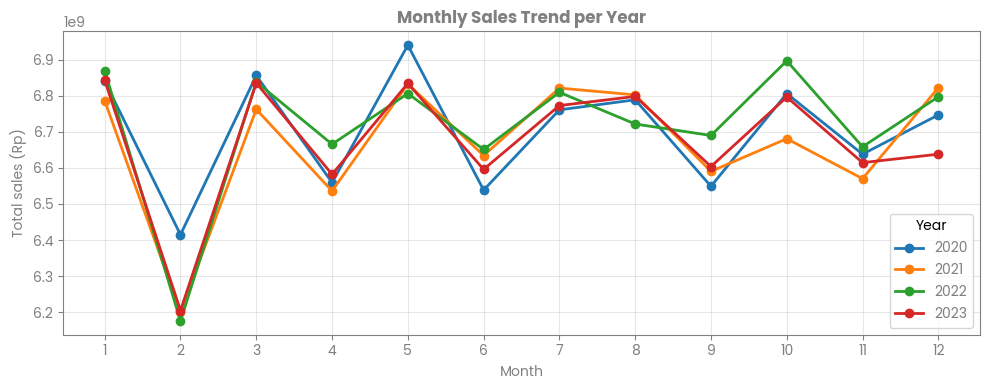

In [ ]:
# Monthly total sales trend
monthly_sales = df.groupby(['year', 'month'])['nett_sales'].sum().reset_index()
monthly_sales.columns = ['year', 'month', 'total_sales']
monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

plt.figure(figsize=(10, 4))
for year in sorted(monthly_sales['year'].unique()):
    data_year = monthly_sales[monthly_sales['year'] == year]
    plt.plot(data_year['month'], data_year['total_sales'], marker='o', linewidth=2, label=str(year))

plt.xlabel('Month')
plt.ylabel('Total sales (Rp)')
plt.title('Monthly Sales Trend per Year')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

In [ ]:
# ANOVA Test for Yearly Sales Differences per Month
results = []

for m in sorted(df['month'].unique()):
    data_month = df[df['month'] == m]
    groups = [data_month[data_month['year'] == y]['nett_sales'] for y in data_month['year'].unique()]
    f_stat, p_val = stats.f_oneway(*groups)

    results.append({
        'month': m,
        'p_value': p_val,
        'significant': p_val < 0.05
    })

anova_results = pd.DataFrame(results)
display(anova_results)

,month,p_value,significant
0,1,0.313515,False
1,2,0.488499,False
2,3,0.987291,False
3,4,0.222055,False
4,5,0.406618,False
5,6,0.232612,False
6,7,0.075357,False
7,8,0.294991,False
8,9,0.287970,False
9,10,0.771890,False


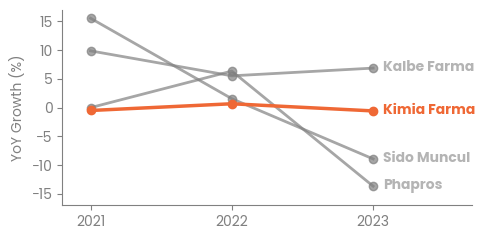

In [ ]:
# Year-over-Year (YoY) Sales Growth Comparison Among Pharmaceutical Companies
sales_comp = {
    "Kalbe Farma": [26.3, 28.9, 30.5, 32.6],
    "Sido Muncul": [3.34, 3.86, 3.92, 3.57],
    "Phapros": [1.10, 1.10, 1.17, 1.01],
    "Kimia Farma": [8.043761e+10, 8.003785e+10, 8.057845e+10, 8.011729e+10],
}

years = [2020, 2021, 2022, 2023]
sales_comp = pd.DataFrame(sales_comp, index=years)
growth = sales_comp.pct_change() * 100

plt.figure(figsize=(5, 2.5))
for col in growth.columns:
    if col == "Kimia Farma":
        plt.plot(growth.index, growth[col], marker='o', color='#ef6835', linewidth=2.5)
    else:
        plt.plot(growth.index, growth[col], marker='o', color='#808080', alpha=0.7, linewidth=2)
    plt.text(growth.index[-1] + 0.07, growth[col].iloc[-1], col, va='center', fontweight='bold', fontsize=10, color='#b4b4b4' if col != "Kimia Farma" else '#ef6835')

plt.xlim([2020.8, 2023.7])
plt.ylim([-17, 17])
plt.xticks([2021, 2022, 2023])
plt.ylabel("YoY Growth (%)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### **Business Case: Breaking Flat Growth Cycle**

**Problem Overview**
- **Kimia Farma YoY Growth**: -0.13% (2020-2023)
- Competitor **Kalbe Farma**: 7% growth in 2023
- Company-specific issue, not market trend

**Key Insights**

**1. Competitive Analysis**
- Losing market share to agile competitor
- Kalbe demonstrates consistent growth is achievable
- Need mindset shift from stable to growth-focused

**2. Sales Pattern Analysis**
- **Average Annual Sales**: Rp 80.3B (Range: 80.0B - 80.6B)
- Predictable seasonal cycle with bi-monthly peaks/troughs
- Deep trough every February
- Rise in odd-numbered months
- Successfully managing seasonality but **failing year-over-year growth**

**Strategic Recommendations**
1. **Analyze Winning Strategy**: Deep-dive into Kalbe's tactics (product, marketing, operations)
2. **Optimize Core Revenue**: Maximize peak seasons, reverse decline segments
3. **Investigate Market Volatility**: Study 2021 spike (Sido Muncul, Phapros) for missed opportunities
4. **Manage Seasonality**: Use low periods for non-sales activities
5. **Drive New Growth**: Product diversification or geographic expansion
6. **Shift Mindset**: From maintenance to aggressive growth mode

## **Geographical Performance Analysis**

In [ ]:
# Branch, City, and Province Performance Summary
branch_summary = df.groupby('branch_id').agg({
    'provinsi': 'first',
    'kota': 'first',
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

province_summary = branch_summary.groupby('provinsi').agg({
    'nett_sales': 'mean',
    'nett_profit': 'mean',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

city_summary = branch_summary.groupby('kota').agg({
    'nett_sales': 'mean',
    'nett_profit': 'mean',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

avg_sales_prov = province_summary['nett_sales'].mean()
avg_profit_prov = province_summary['nett_profit'].mean()
avg_branch_rating_prov = province_summary['rating_cabang'].mean()
avg_trans_rating_prov = province_summary['rating_transaksi'].mean()

avg_sales_city = city_summary['nett_sales'].mean()
avg_profit_city = city_summary['nett_profit'].mean()
avg_branch_rating_city = city_summary['rating_cabang'].mean()
avg_trans_rating_city = city_summary['rating_transaksi'].mean()

sales_min_prov, sales_max_prov = province_summary['nett_sales'].min(), province_summary['nett_sales'].max()
profit_min_prov, profit_max_prov = province_summary['nett_profit'].min(), province_summary['nett_profit'].max()
rating_min_prov, rating_max_prov = province_summary['rating_cabang'].min(), province_summary['rating_cabang'].max()
trans_min_prov, trans_max_prov = province_summary['rating_transaksi'].min(), province_summary['rating_transaksi'].max()

sales_min_city, sales_max_city = city_summary['nett_sales'].min(), city_summary['nett_sales'].max()
profit_min_city, profit_max_city = city_summary['nett_profit'].min(), city_summary['nett_profit'].max()
rating_min_city, rating_max_city = city_summary['rating_cabang'].min(), city_summary['rating_cabang'].max()
trans_min_city, trans_max_city = city_summary['rating_transaksi'].min(), city_summary['rating_transaksi'].max()

print("=== Average per Province ===")
print("Avg Sales/Province : Rp", round(avg_sales_prov / 1_000_000, 1), "M",
      f"(Range Rp {round(sales_min_prov / 1_000_000, 1)}M – Rp {round(sales_max_prov / 1_000_000, 1)}M)")
print("Avg Profit/Province: Rp", round(avg_profit_prov / 1_000_000, 1), "M",
      f"(Range Rp {round(profit_min_prov / 1_000_000, 1)}M – Rp {round(profit_max_prov / 1_000_000, 1)}M)")
print("Avg Branch Rating  :", round(avg_branch_rating_prov, 2),
      f"(Range {round(rating_min_prov, 2)} – {round(rating_max_prov, 2)})")
print("Avg Transaction Rating:", round(avg_trans_rating_prov, 2),
      f"(Range {round(trans_min_prov, 2)} – {round(trans_max_prov, 2)})")

print("\n=== Average per City ===")
print("Avg Sales/City     : Rp", round(avg_sales_city / 1_000_000, 1), "M",
      f"(Range Rp {round(sales_min_city / 1_000_000, 1)}M – Rp {round(sales_max_city / 1_000_000, 1)}M)")
print("Avg Profit/City    : Rp", round(avg_profit_city / 1_000_000, 1), "M",
      f"(Range Rp {round(profit_min_city / 1_000_000, 1)}M – Rp {round(profit_max_city / 1_000_000, 1)}M)")
print("Avg Branch Rating  :", round(avg_branch_rating_city, 2),
      f"(Range {round(rating_min_city, 2)} – {round(rating_max_city, 2)})")
print("Avg Transaction Rating:", round(avg_trans_rating_city, 2),
      f"(Range {round(trans_min_city, 2)} – {round(trans_max_city, 2)})")

=== Average per Province ===
Avg Sales/Province : Rp 186.0 M (Range Rp 182.7M – Rp 189.6M)
Avg Profit/Province: Rp 52.8 M (Range Rp 51.9M – Rp 54.0M)
Avg Branch Rating  : 4.46 (Range 4.33 – 4.64)
Avg Transaction Rating: 4.0 (Range 3.99 – 4.01)

=== Average per City ===
Avg Sales/City     : Rp 186.2 M (Range Rp 181.5M – Rp 192.1M)
Avg Profit/City    : Rp 52.9 M (Range Rp 51.6M – Rp 54.6M)
Avg Branch Rating  : 4.45 (Range 4.25 – 4.64)
Avg Transaction Rating: 4.0 (Range 3.99 – 4.01)


Provinces with Significantly High Efficiency (Z > 2):
              provinsi  sales_per_branch  z_score_efficiency
12  Kalimantan Selatan      1.896217e+08            2.124407
7                Jambi      1.895683e+08            2.092899

Provinces with Significantly Low Efficiency (Z < -2):
No provinces with significantly low efficiency.

Cities with Significantly High Efficiency (Z > 2):
        kota  sales_per_branch  z_score_efficiency
34  Magelang      1.920659e+08            2.530924
9      Bogor      1.921187e+08            2.553573

Cities with Significantly Low Efficiency (Z < -2):
No cities with significantly low efficiency.



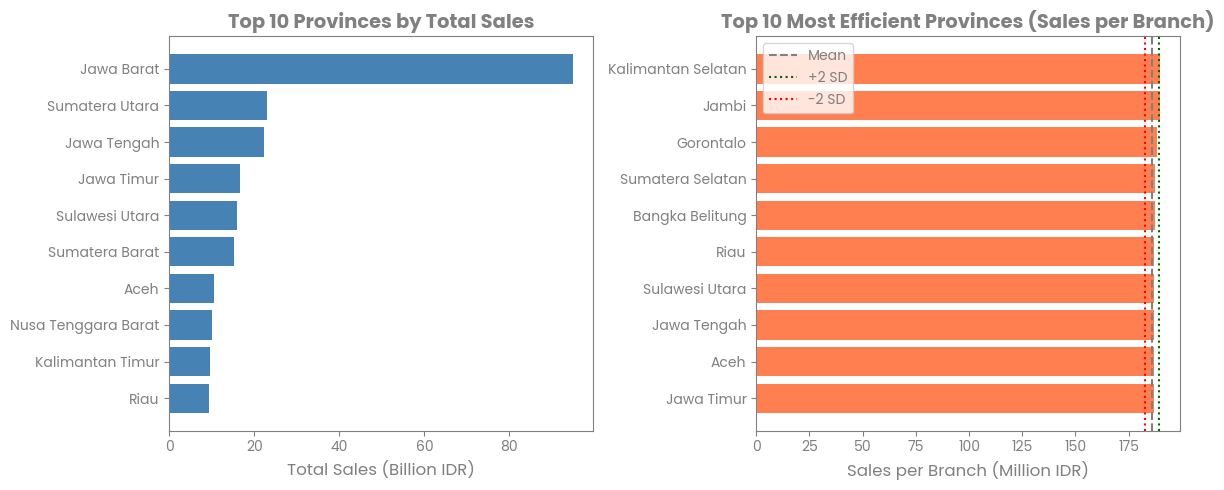

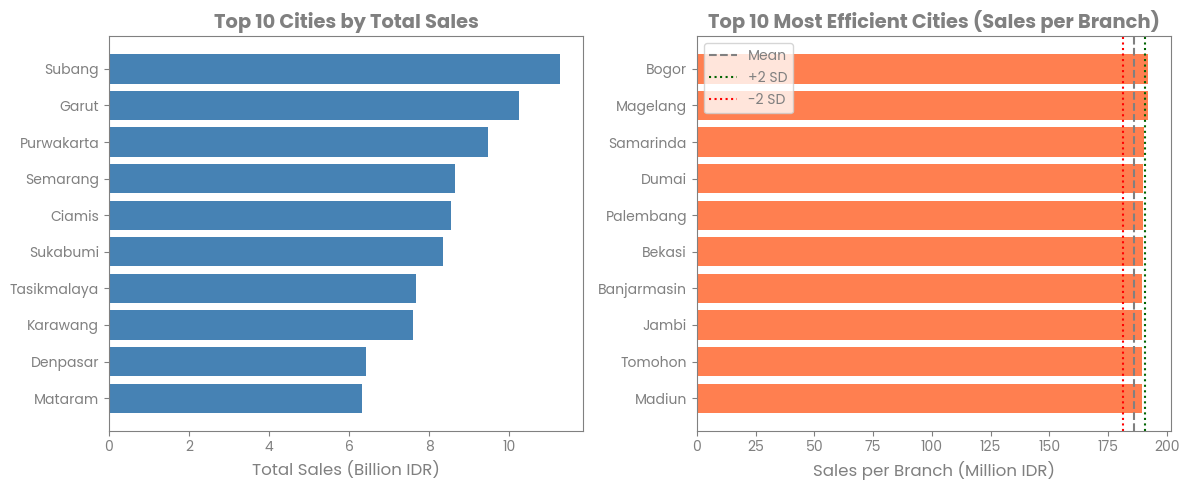

In [ ]:
# Province and City Efficiency Analysis with Top Sales and Sales per Branch
province_metrics = df.groupby('provinsi').agg({
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'transaction_id': 'count',
    'branch_id': 'nunique'
}).reset_index()

province_metrics.columns = ['provinsi', 'total_sales', 'total_profit', 'transactions', 'branch_count']
province_metrics = province_metrics.sort_values('total_sales', ascending=False)
province_metrics['sales_per_branch'] = province_metrics['total_sales'] / province_metrics['branch_count']

province_metrics['z_score_efficiency'] = (province_metrics['sales_per_branch'] - province_metrics['sales_per_branch'].mean()) / province_metrics['sales_per_branch'].std()
significant_eff_provinces_high = province_metrics[province_metrics['z_score_efficiency'] > 2]
significant_eff_provinces_low = province_metrics[province_metrics['z_score_efficiency'] < -2]

print("Provinces with Significantly High Efficiency (Z > 2):")
if significant_eff_provinces_high.empty:
    print("No provinces with significantly high efficiency.")
else:
    print(significant_eff_provinces_high[['provinsi', 'sales_per_branch', 'z_score_efficiency']])
print()

print("Provinces with Significantly Low Efficiency (Z < -2):")
if significant_eff_provinces_low.empty:
    print("No provinces with significantly low efficiency.")
else:
    print(significant_eff_provinces_low[['provinsi', 'sales_per_branch', 'z_score_efficiency']])
print()

city_metrics = df.groupby('kota').agg({
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'transaction_id': 'count',
    'branch_id': 'nunique'
}).reset_index()

city_metrics.columns = ['kota', 'total_sales', 'total_profit', 'transactions', 'branch_count']
city_metrics = city_metrics.sort_values('total_sales', ascending=False)
city_metrics['sales_per_branch'] = city_metrics['total_sales'] / city_metrics['branch_count']

city_metrics['z_score_efficiency'] = (city_metrics['sales_per_branch'] - city_metrics['sales_per_branch'].mean()) / city_metrics['sales_per_branch'].std()
significant_eff_cities_high = city_metrics[city_metrics['z_score_efficiency'] > 2]
significant_eff_cities_low = city_metrics[city_metrics['z_score_efficiency'] < -2]

print("Cities with Significantly High Efficiency (Z > 2):")
if significant_eff_cities_high.empty:
    print("No cities with significantly high efficiency.")
else:
    print(significant_eff_cities_high[['kota', 'sales_per_branch', 'z_score_efficiency']])
print()

print("Cities with Significantly Low Efficiency (Z < -2):")
if significant_eff_cities_low.empty:
    print("No cities with significantly low efficiency.")
else:
    print(significant_eff_cities_low[['kota', 'sales_per_branch', 'z_score_efficiency']])
print()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

top_provinces = province_metrics.head(10)
axes[0].barh(top_provinces['provinsi'], top_provinces['total_sales'] / 1e9, color='steelblue')
axes[0].set_xlabel('Total Sales (Billion IDR)', fontsize=12)
axes[0].set_title('Top 10 Provinces by Total Sales', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

top_efficiency = province_metrics.nlargest(10, 'sales_per_branch')
axes[1].barh(top_efficiency['provinsi'], top_efficiency['sales_per_branch'] / 1e6, color='coral')
axes[1].set_xlabel('Sales per Branch (Million IDR)', fontsize=12)
axes[1].set_title('Top 10 Most Efficient Provinces (Sales per Branch)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

mean_eff = province_metrics['sales_per_branch'].mean()
std_eff = province_metrics['sales_per_branch'].std()

axes[1].axvline(mean_eff / 1e6, color='gray', linestyle='--', label='Mean')
axes[1].axvline((mean_eff + 2 * std_eff) / 1e6, color='darkgreen', linestyle=':', label='+2 SD')
axes[1].axvline((mean_eff - 2 * std_eff) / 1e6, color='red', linestyle=':', label='-2 SD')
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

top_cities = city_metrics.head(10)
axes[0].barh(top_cities['kota'], top_cities['total_sales'] / 1e9, color='steelblue')
axes[0].set_xlabel('Total Sales (Billion IDR)', fontsize=12)
axes[0].set_title('Top 10 Cities by Total Sales', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

top_efficiency = city_metrics.nlargest(10, 'sales_per_branch')
axes[1].barh(top_efficiency['kota'], top_efficiency['sales_per_branch'] / 1e6, color='coral')
axes[1].set_xlabel('Sales per Branch (Million IDR)', fontsize=12)
axes[1].set_title('Top 10 Most Efficient Cities (Sales per Branch)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

mean_eff = city_metrics['sales_per_branch'].mean()
std_eff = city_metrics['sales_per_branch'].std()

axes[1].axvline(mean_eff / 1e6, color='gray', linestyle='--', label='Mean')
axes[1].axvline((mean_eff + 2 * std_eff) / 1e6, color='darkgreen', linestyle=':', label='+2 SD')
axes[1].axvline((mean_eff - 2 * std_eff) / 1e6, color='red', linestyle=':', label='-2 SD')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Top 3 Products in High-Efficiency Provinces & Cities
province_filter  = ['Kalimantan Selatan', 'Jambi']
df_filtered = df[df['provinsi'].isin(province_filter )]
top3_prov = (df_filtered.groupby(['provinsi', 'product_name_short'], as_index=False)['nett_sales'].sum().sort_values(['provinsi', 'nett_sales'], ascending=[True, False]).groupby('provinsi').head(3))
display(top3_prov)

city_filter  = ['Magelang', 'Bogor']
df_filtered = df[df['kota'].isin(city_filter )]
top3_city = (df_filtered.groupby(['kota', 'product_name_short'], as_index=False)['nett_sales'].sum().sort_values(['kota', 'nett_sales'], ascending=[True, False]).groupby('kota').head(3))
display(top3_city)

,provinsi,product_name_short,nett_sales
5,Jambi,Psycholeptics (Anxiolytics),614375047.0
6,Jambi,Psycholeptics (Hypnotics/Sedatives),578106104.0
2,Jambi,Analgesic/Antipyretic (Salicylates),478067697.0
14,Kalimantan Selatan,Psycholeptics (Hypnotics/Sedatives),828094620.0
13,Kalimantan Selatan,Psycholeptics (Anxiolytics),823340388.0
10,Kalimantan Selatan,Analgesic/Antipyretic (Salicylates),667457875.0


,kota,product_name_short,nett_sales
6,Bogor,Psycholeptics (Hypnotics/Sedatives),482323789.0
5,Bogor,Psycholeptics (Anxiolytics),475048482.0
2,Bogor,Analgesic/Antipyretic (Salicylates),406512498.0
14,Magelang,Psycholeptics (Hypnotics/Sedatives),783071753.0
13,Magelang,Psycholeptics (Anxiolytics),754167476.0
10,Magelang,Analgesic/Antipyretic (Salicylates),634480645.0


### **Geographic Analysis: Mid-Tier Cities Win Big**

**Performance Overview**

1. **Provincial Level**
    - **Top Revenue**: Jabar (~75B), followed by Sumut, Jateng, Jatim, Sulut
    - **Most Efficient**: Kalsel, Jambi, Gorontalo, Sumsel, Babel (~100M+ sales/branch)
    - **Avg Performance**: Revenue Rp 186.0M | Profit Rp 52.8M | Margin ~28-30%

2. **City Level**
    - **Top Revenue**: Subang (~10B), Garut, Purwakarta, Semarang, Ciamis
    - **Most Efficient**: Bogor, Magelang, Samarinda, Dumai, Palembang (~150M+ sales/branch)
    - **Avg Performance**: Revenue Rp 186.2M | Profit Rp 52.9M

**Success Pattern**
- **Products**: 2 of top 3 = Psycholeptics
- **Location**: Mid-tier cities, NOT metropolitan
- **Profit**: 28-30% margin consistently
- **Volume**: High transaction count

**Recommended Actions**
1. **Replicate**: Scale proven best practices to other branches
2. **Audit & Secure**: Prioritize compliance audits for Psycholeptics
3. **Expansion**: Target similar mid-tier cities
4. **Deep Dive**: Analyze local success factors

**Key Insight**

Mid-tier cities outperform major metros in efficiency and profitability. Focus expansion on similar demographic profiles.

## **Branch Performance Analysis**

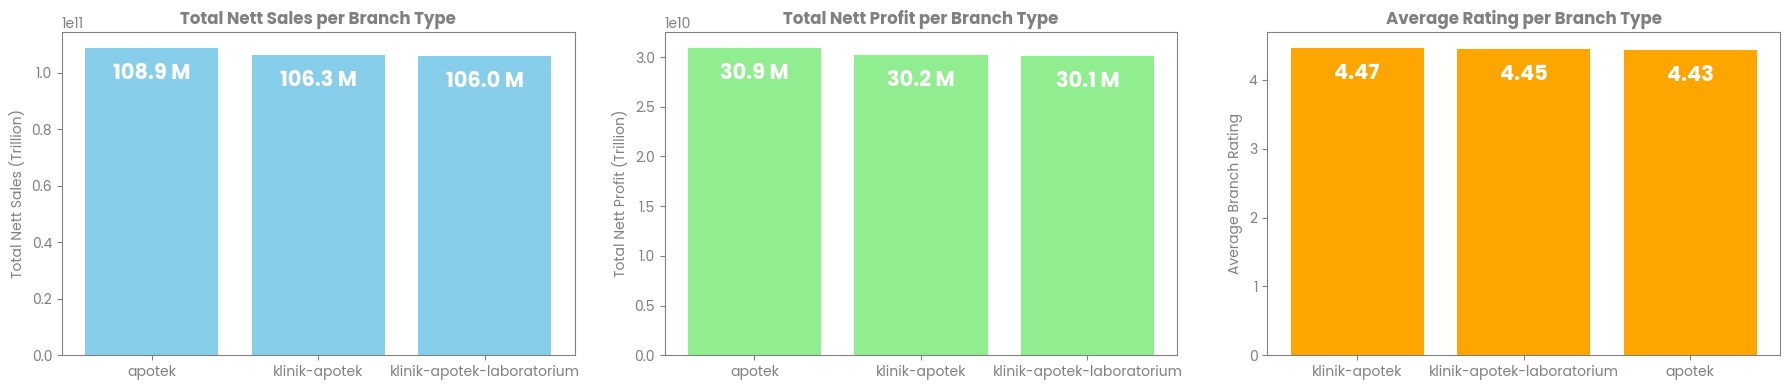

In [ ]:
# Branch Type Performance Visualization
sales_profit_per_branch = df.groupby('branch_type')[['nett_sales', 'nett_profit']].sum().reset_index()
sales_profit_per_branch = sales_profit_per_branch.sort_values('nett_sales', ascending=False)

rating_per_branch = df.groupby('branch_type')['rating_cabang'].mean().reset_index()
rating_per_branch = rating_per_branch.sort_values('rating_cabang', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Total Nett Sales
bars1 = axes[0].bar(sales_profit_per_branch['branch_type'], sales_profit_per_branch['nett_sales'], color='skyblue')
axes[0].set_title('Total Nett Sales per Branch Type')
axes[0].set_xlabel('')
axes[0].set_ylabel('Total Nett Sales (Trillion)')

for bar in bars1:
    height = bar.get_height()
    label = f'{height / 1e9:.1f} M'
    axes[0].text(bar.get_x() + bar.get_width()/2, height * 0.95, label, ha='center', va='top', color='white', fontweight='bold', fontsize=15)

# Total Nett Profit
bars2 = axes[1].bar(sales_profit_per_branch['branch_type'], sales_profit_per_branch['nett_profit'], color='lightgreen')
axes[1].set_title('Total Nett Profit per Branch Type')
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Nett Profit (Trillion)')

for bar in bars2:
    height = bar.get_height()
    label = f'{height / 1e9:.1f} M'
    axes[1].text(bar.get_x() + bar.get_width()/2, height * 0.95, label, ha='center', va='top', color='white', fontweight='bold', fontsize=15)

# Average Rating
bars3 = axes[2].bar(rating_per_branch['branch_type'], rating_per_branch['rating_cabang'], color='orange')
axes[2].set_title('Average Rating per Branch Type')
axes[2].set_xlabel('')
axes[2].set_ylabel('Average Branch Rating')

for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2, height * 0.95, f'{height:.2f}', ha='center', va='top', color='white', fontweight='bold', fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
# Statistical Analysis for Branch Performance
sales_profit_per_branch = (df.groupby('branch_type')[['nett_sales', 'nett_profit']].sum().reset_index().sort_values('nett_sales', ascending=False))
rating_per_branch = (df.groupby('branch_type')['rating_cabang'].mean().reset_index().sort_values('rating_cabang', ascending=False))

# ANOVA for all metrics
def anova_test(df, col, group_col='branch_type'):
    groups = [group[col].values for _, group in df.groupby(group_col)]
    f_stat, p_val = stats.f_oneway(*groups)

    grand_mean = df[col].mean()
    ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
    ss_total = sum((df[col] - grand_mean)**2)
    eta_sq = ss_between / ss_total

    if eta_sq < 0.01:
        eff = "Small"
    elif eta_sq < 0.06:
        eff = "Medium"
    elif eta_sq < 0.14:
        eff = "Large"
    else:
        eff = "Very Large"

    signif = "Significant" if p_val < 0.05 else "Not Significant"
    return f_stat, p_val, eta_sq, eff, signif

metrics = ['nett_sales', 'nett_profit', 'rating_cabang']
results = []
for m in metrics:
    f, p, eta, eff, signif = anova_test(df, m)
    results.append([m, f, p, eta, eff, signif])

anova_df = pd.DataFrame(results, columns=['Metric', 'F-statistic', 'p-value', 'Eta Squared', 'Effect Size', 'Significance'])
display(anova_df)
print()

# POST-HOC (Tukey HSD)
for m in metrics:
    f, p, eta, eff, signif = anova_test(df, m)
    if p < 0.05:
        tukey = pairwise_tukeyhsd(endog=df[m], groups=df['branch_type'], alpha=0.05)
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        display(tukey_df)

,Metric,F-statistic,p-value,Eta Squared,Effect Size,Significance
0,nett_sales,1.085525,3.377251e-01,0.000003,Small,Not Significant
1,nett_profit,1.328786,2.647992e-01,0.000004,Small,Not Significant
2,rating_cabang,734.614455,2.037131e-319,0.002180,Small,Significant


,group1,group2,meandiff,p-adj,lower,upper,reject
0,apotek,klinik-apotek,0.0367,0.0,0.0344,0.0389,True
1,apotek,klinik-apotek-laboratorium,0.0217,0.0,0.0195,0.0240,True
2,klinik-apotek,klinik-apotek-laboratorium,-0.0149,0.0,-0.0172,-0.0127,True


In [ ]:
# Branch-Level Summary Statistics
branch_summary = df.groupby('branch_id').agg({
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

avg_sales_per_branch = branch_summary['nett_sales'].mean()
avg_profit_per_branch = branch_summary['nett_profit'].mean()
avg_branch_rating = branch_summary['rating_cabang'].mean()
avg_transaction_rating = branch_summary['rating_transaksi'].mean()

sales_min, sales_max = branch_summary['nett_sales'].min(), branch_summary['nett_sales'].max()
profit_min, profit_max = branch_summary['nett_profit'].min(), branch_summary['nett_profit'].max()
branch_rating_min, branch_rating_max = branch_summary['rating_cabang'].min(), branch_summary['rating_cabang'].max()
transaction_rating_min, transaction_rating_max = branch_summary['rating_transaksi'].min(), branch_summary['rating_transaksi'].max()

print("Avg Sales per Branch      : Rp", round(avg_sales_per_branch / 1_000_000, 1), "M",
      f"(Range Rp {round(sales_min / 1_000_000, 1)}M – Rp {round(sales_max / 1_000_000, 1)}M)")
print("Avg Profit per Branch     : Rp", round(avg_profit_per_branch / 1_000_000, 1), "M",
      f"(Range Rp {round(profit_min / 1_000_000, 1)}M – Rp {round(profit_max / 1_000_000, 1)}M)")
print("Avg Branch Rating         :", round(avg_branch_rating, 2),
      f"(Range {round(branch_rating_min, 2)} – {round(branch_rating_max, 2)})")
print("Avg Transaction Rating    :", round(avg_transaction_rating, 2),
      f"(Range {round(transaction_rating_min, 2)} – {round(transaction_rating_max, 2)})")

Avg Sales per Branch      : Rp 186.2 M (Range Rp 152.9M – Rp 220.2M)
Avg Profit per Branch     : Rp 52.9 M (Range Rp 43.3M – Rp 62.9M)
Avg Branch Rating         : 4.45 (Range 3.9 – 5.0)
Avg Transaction Rating    : 4.0 (Range 3.9 – 4.09)


,bsc_segment,nett_sales,nett_profit,rating_cabang,rating_transaksi,branch_count
0,Low,69.2,18.0,4.448232,3.999223,1725
1,Medium,59.1,17.5,4.448232,4.000660,1725
2,High,57.9,17.4,4.501990,4.000450,1725


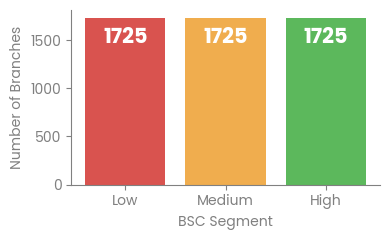

In [ ]:
# Balanced Scorecard Segmentation
components = ['nett_sales', 'nett_profit', 'rating_cabang']
for col in components:
    if col not in df.columns:
        raise KeyError(f"Kolom '{col}' tidak ditemukan di DataFrame.")

for col in components:
    df[f'{col}_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df['bsc_score'] = df[[f'{c}_norm' for c in components]].mean(axis=1)
bins = [0, 0.53077411, 0.67846566, 1]
labels = ['Low', 'Medium', 'High']
df['bsc_segment'] = pd.cut(df['bsc_score'], bins=bins, labels=labels, include_lowest=True)

branch_summary = df.groupby(['branch_id', 'bsc_segment']).agg({
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

segment_summary = branch_summary.groupby('bsc_segment').agg({
    'nett_sales': 'mean',
    'nett_profit': 'mean',
    'rating_cabang': 'mean',
    'rating_transaksi': 'mean',
    'branch_id': 'count'
}).rename(columns={'branch_id': 'branch_count'}).reset_index()

segment_summary['nett_sales'] = (segment_summary['nett_sales'] / 1_000_000).round(1)
segment_summary['nett_profit'] = (segment_summary['nett_profit'] / 1_000_000).round(1)
display(segment_summary)
print()

plt.figure(figsize=(4, 2.5))
bars = plt.bar(segment_summary['bsc_segment'], segment_summary['branch_count'], color=['#d9534f', '#f0ad4e', '#5cb85c'])  # Low, Medium, High
plt.xlabel('BSC Segment')
plt.ylabel('Number of Branches')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05*bar.get_height(), int(bar.get_height()), ha='center', color='white', va='top', fontweight='bold', fontsize=15)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

### **Business Model Analysis**

**Proven Efficiency of Pharmacy-Only Model**

| Metric | Pharmacy | Pharmacy-Clinic | Pharmacy-Clinic-Lab |
|--------|----------|-----------------|---------------------|
| Avg. Sales | IDR 186.8M | IDR 186.2M | IDR 185.6M |
| Avg. Profit | IDR 53.1M | IDR 52.9M | IDR 52.7M |
| Transactions | 391 | 390 | 389 |
| Profit Margin % | **28.41%** | 28.40% | 28.40% |

**Key Finding**
* **Pharmacy-Only** is the top-performing business model across all metrics. While all three formats show similar performance (~28.40% margin), the Pharmacy-Only model maintains slight advantages in sales, profit, and efficiency.

* **Core insight**: Identical top-selling products and discount strategies across formats confirm the **pharmacy component drives business**, not supplementary clinic/lab services.

**Strategic Recommendations**
1. **Prioritize Pharmacy-Only for Expansion**: Allocate future capital to this proven, scalable, efficient format
2. **Cost-Benefit Analysis of Integrated Models**: Quantify ROI of clinic and lab components in "Clinic & Pharmacy" and "Clinic-Pharmacy-Lab" formats

**Branch Performance Gap Analysis**
- **Avg Sales/Branch**: Rp 186.2M (Range: 152.9M - 220.2M)
- **Avg Profit/Branch**: Rp 52.9M (Range: 43.3M - 62.9M)
- **Avg Branch Rating**: 4.45/5.0 (Range: 3.9 - 5.0)
- **Avg Transaction Rating**: 4.0 (Range: 3.9 - 4.09)

| Segment | Avg Revenue | Avg Margin | Avg Rating | Count |
|---------|-------------|------------|------------|-------|
| **High** | Rp 129.9M | **30.0%** | 4.45 | 1,725 |
| **Medium** | Rp 44.9M | 26.1% | 4.45 | 1,725 |
| **Low** | Rp 11.3M | 20.4% | 4.45 | 1,725 |

**Critical Issues**
- **Identical ratings (4.45) across all segments** - rating system fails to differentiate performance
- Sales and profit dominate segmentation, not customer metrics
- **High performers achieve 30% margins vs 20% in Low** (50% better)
- High segment delivers **11.5x sales** and **17x profit** versus Low

**Action Plan**
1. **Elevate Low Performers**: Move top 15% of Low segment to Medium through targeted interventions
2. **Margin Optimization**: Replicate High segment best practices (product mix, cost control) across other branches

**Methodology Note**

BSC (Balanced Scorecard) framework equally weights branch rating, transaction rating, sales, and profit across all 5,175 branches (1,725 per segment).

## **Product Performance and Profitability Analysis**

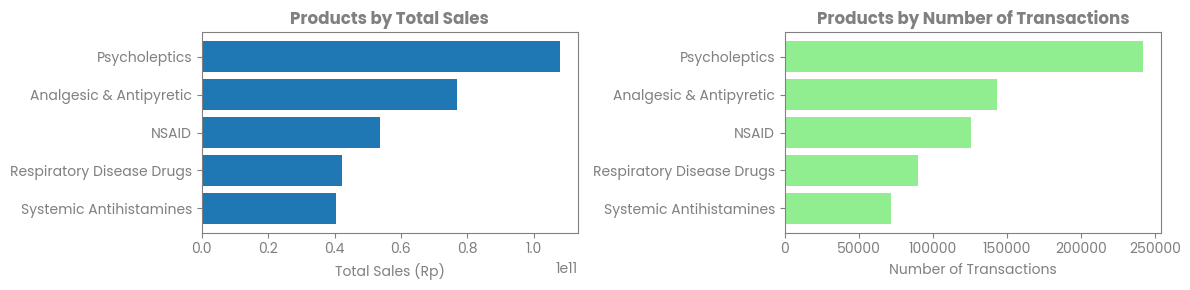

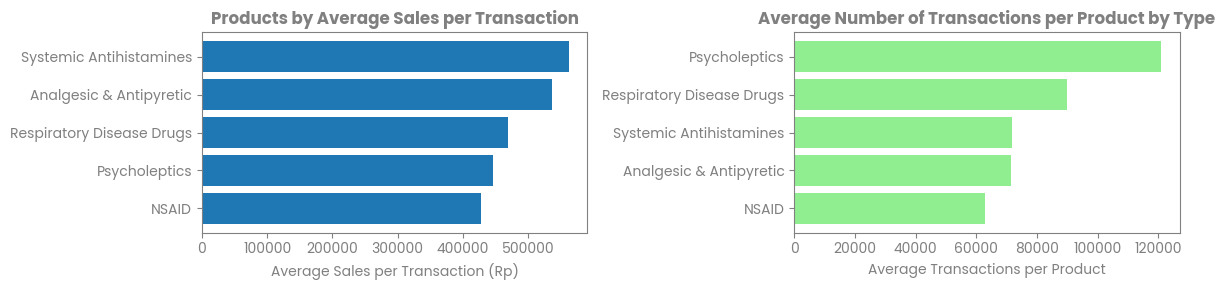

In [ ]:
# Product Performance Overview
product_performance = df.groupby(['product_type']).agg({
    'nett_sales': 'sum',
    'nett_profit': 'sum',
    'transaction_id': 'count',
    'actual_price': 'mean'
}).reset_index()
product_performance.columns = ['product_type', 'total_sales', 'total_profit', 'total_transactions', 'avg_price']
product_performance = product_performance.sort_values('total_sales', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].barh(range(len(product_performance)), product_performance['total_sales'])
axes[0].set_yticks(range(len(product_performance)))
axes[0].set_yticklabels(product_performance['product_type'].str[:50])
axes[0].set_xlabel('Total Sales (Rp)')
axes[0].set_title('Products by Total Sales')
axes[0].invert_yaxis()

product_performance = product_performance.sort_values('total_transactions', ascending=False)

axes[1].barh(range(len(product_performance)), product_performance['total_transactions'], color='lightgreen')
axes[1].set_yticks(range(len(product_performance)))
axes[1].set_yticklabels(product_performance['product_type'].str[:50])
axes[1].set_xlabel('Number of Transactions')
axes[1].set_title('Products by Number of Transactions')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Average nett_sales per transaction per product type
avg_sales_per_type = (df.groupby('product_type').agg({'nett_sales': 'mean'}).reset_index().rename(columns={'nett_sales': 'avg_sales_per_transaction'}))
avg_trans_per_type = (df.groupby(['product_type', 'product_name'])['transaction_id'].count().groupby('product_type').mean().reset_index(name='avg_transactions_per_product'))
product_performance = avg_sales_per_type.merge(avg_trans_per_type, on='product_type')

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Average sales per transaction
product_performance = product_performance.sort_values('avg_sales_per_transaction', ascending=False)
axes[0].barh(range(len(product_performance)), product_performance['avg_sales_per_transaction'])
axes[0].set_yticks(range(len(product_performance)))
axes[0].set_yticklabels(product_performance['product_type'].str[:50])
axes[0].set_xlabel('Average Sales per Transaction (Rp)')
axes[0].set_title('Products by Average Sales per Transaction')
axes[0].invert_yaxis()

# Average number of transactions per product
product_performance = product_performance.sort_values('avg_transactions_per_product', ascending=False)
axes[1].barh(range(len(product_performance)), product_performance['avg_transactions_per_product'], color='lightgreen')
axes[1].set_yticks(range(len(product_performance)))
axes[1].set_yticklabels(product_performance['product_type'].str[:50])
axes[1].set_xlabel('Average Transactions per Product')
axes[1].set_title('Average Number of Transactions per Product by Type')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

ABC Product Analysis Results:


,product_name,nett_sales,sales_percentage,cumulative_percentage,abc_class
7,"Psycholeptics drugs, Hypnotics and sedatives d...",5.502269e+10,0.171319,0.171319,A
6,"Psycholeptics drugs, Anxiolytic drugs",5.298017e+10,0.164959,0.336278,A
5,"Other analgesics and antipyretics, Salicylic a...",4.323047e+10,0.134603,0.470881,A
3,Drugs for obstructive airway diseases,4.215588e+10,0.131257,0.602137,A
2,Antihistamines for systemic use,4.040724e+10,0.125812,0.727950,A
4,"Other analgesics and antipyretics, Pyrazolones...",3.356598e+10,0.104511,0.832461,B
1,"Anti-inflammatory and antirheumatic products, ...",2.791694e+10,0.086922,0.919383,B
0,"Anti-inflammatory and antirheumatic products, ...",2.589182e+10,0.080617,1.000000,C



ABC Class Summary:


,proportion
abc_class,
A,0.625
B,0.250
C,0.125


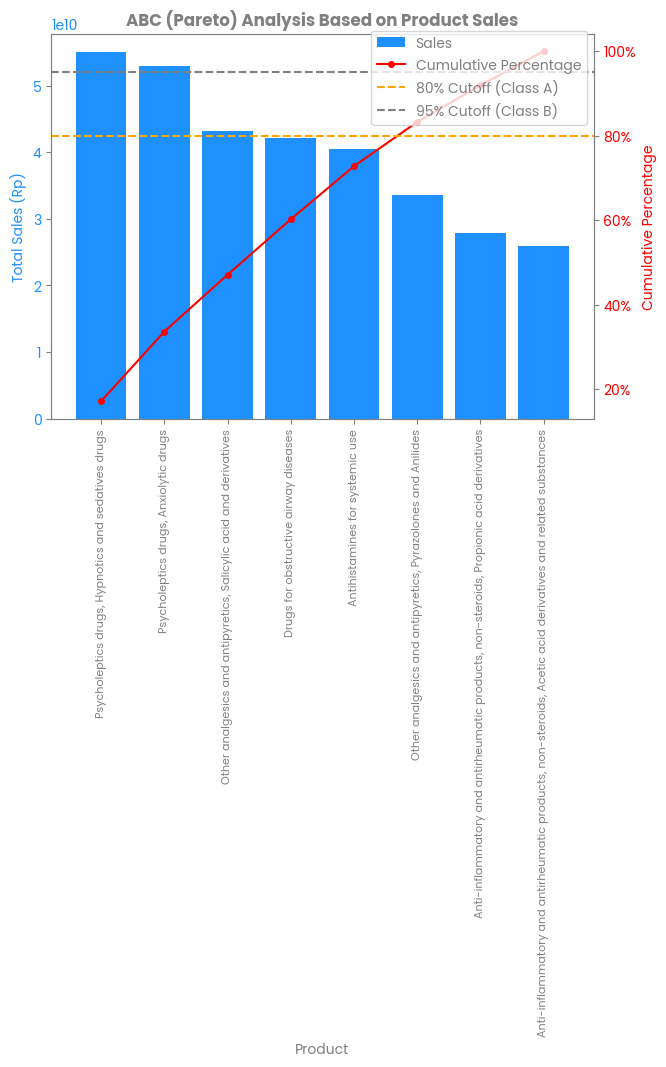

In [ ]:
# ABC–Pareto Analysis of Product Sales Contribution
product_sales = df.groupby('product_name')['nett_sales'].sum().reset_index()
product_sales = product_sales.sort_values(by='nett_sales', ascending=False)

total_all_sales = product_sales['nett_sales'].sum()
product_sales['sales_percentage'] = (product_sales['nett_sales'] / total_all_sales)
product_sales['cumulative_percentage'] = product_sales['sales_percentage'].cumsum()

def assign_abc_class(cumulative_perc):
    """
    Classify products based on cumulative percentage:
    - Class A: Top 80% of sales
    - Class B: Next 15% (80% - 95%)
    - Class C: Remaining 5% (above 95%)
    """
    if cumulative_perc <= 0.80:
        return 'A'
    elif cumulative_perc <= 0.95:
        return 'B'
    else:
        return 'C'

product_sales['abc_class'] = product_sales['cumulative_percentage'].apply(assign_abc_class)

print("ABC Product Analysis Results:")
display(product_sales)

print("\nABC Class Summary:")
display(product_sales['abc_class'].value_counts(normalize=True).sort_index())

fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.bar(product_sales['product_name'], product_sales['nett_sales'], color='dodgerblue', label='Sales')
ax1.set_xlabel('Product')
ax1.set_ylabel('Total Sales (Rp)', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticklabels(product_sales['product_name'], rotation=90, ha='center', fontsize=8)

ax2 = ax1.twinx()
ax2.plot(product_sales['product_name'], product_sales['cumulative_percentage'], color='red', marker='o', ms=4, label='Cumulative Percentage')
ax2.set_ylabel('Cumulative Percentage', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.axhline(y=0.8, color='orange', linestyle='--', label='80% Cutoff (Class A)')
ax2.axhline(y=0.95, color='gray', linestyle='--', label='95% Cutoff (Class B)')

plt.title('ABC (Pareto) Analysis Based on Product Sales')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()

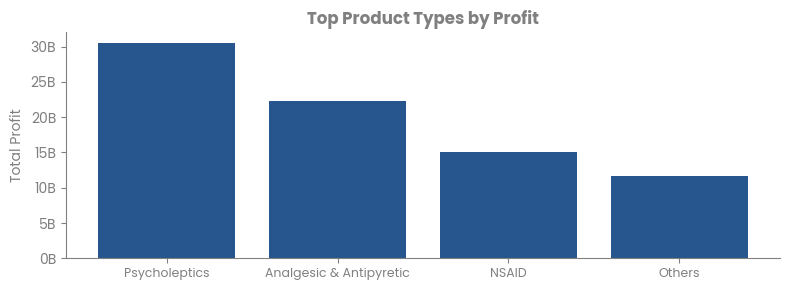

In [ ]:
# Top Product Types by Profit
product_summary = (df.groupby('product_type')['nett_profit'].sum().sort_values(ascending=False).reset_index())
top3 = product_summary.head(3)
others_avg = product_summary.iloc[3:]['nett_profit'].mean()

others_row = {
    'product_type': 'Others',
    'nett_profit': others_avg
}
top3_plus_avg = pd.concat([top3, pd.DataFrame([others_row])], ignore_index=True)

plt.figure(figsize=(8, 3))
plt.bar(top3_plus_avg['product_type'], top3_plus_avg['nett_profit'] / 1e9, color='#003879', alpha=0.85)

plt.title('Top Product Types by Profit')
plt.xlabel('')
plt.ylabel('Total Profit')
plt.xticks(rotation=0, ha='center', fontsize=9)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}B'))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### **Product Portfolio Analysis: Uncovering Value Drivers**

**Portfolio Segmentation by Priority Level**
- **High Priority**: 78 SKU (Rp 72B+ contribution)
- **Medium Priority**: 32 SKU (Rp 13B+ contribution)
- **Low Priority**: 40 SKU (Rp 4B+ contribution)

**Portfolio Segmentation by Category**
Top profit contributors:
1. **Psycholeptic**: ~30B
2. **Analgesic & Antipyretic**: ~21B
3. **NSAID**: ~15B
4. **Others**: ~12B

**Concentration Pattern**
- Sharp 10x profit drop between high and low priority segments
- Psycholeptics dominance at 55% suggests deeper category penetration potential
- 40 low-priority SKUs = untapped margin improvement opportunity via strategic bundling
- Top products follow Pareto principle (small SKU count drives majority of profit)

**Strategic Actions by Priority**

1. **High Priority (78 SKU)**: Protect & Optimize
    - Ensure full availability for valid Rx
    - Maintain secure & compliant safety stock
    - Strengthen supplier relationships for these 78 vital products

2. **Medium Priority (32 SKU)**: Growth Potential
    - Monitor closely for items with potential to move to Class A
    - Use ethical HCP engagement while maintaining balanced stock

3. **Low Priority (40 SKU)**: Margin Enhancement
    - Despite high transactions, these products don't drive profit
    - Reduce cost-to-serve
    - Use bundling strategies to boost margins instead of standalone sales

**Analysis Framework**

Cumulative percentage curve shows typical long-tail distribution where few SKUs drive most value.

## **Customer RFM Segmentation Analysis**

In [ ]:
# Customer RFM Segmentation Analysis
analysis_date = df['date'].max() + pd.Timedelta(days=1)
print(f"Analysis Date: {analysis_date.date()}")

rfm_data = df.groupby('customer_name').agg({
    'date': lambda x: (analysis_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'nett_sales': 'sum'  # Monetary
}).reset_index()

rfm_data.columns = ['customer_name', 'recency', 'frequency', 'monetary']

# Scoring 1-5 based on quintiles
rfm_data['R'] = pd.qcut(rfm_data['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_data['F'] = pd.qcut(rfm_data['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_data['M'] = pd.qcut(rfm_data['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

rfm_data['R'] = rfm_data['R'].astype(int)
rfm_data['F'] = rfm_data['F'].astype(int)
rfm_data['M'] = rfm_data['M'].astype(int)
rfm_data['rfm_score'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str) + rfm_data['M'].astype(str)

# Segment mapping based on RFM score
segment_map = {
    'Champions': ['555', '554', '544', '545', '454', '455', '445'],
    'Loyal': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalists': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About to Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
    'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'Hibernating': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Lost': ['111', '112', '121', '131', '141', '151']
}

segment_dict = {}
for segment, scores in segment_map.items():
    for score in scores:
        segment_dict[score] = segment

rfm_data['rfm_segment'] = rfm_data['rfm_score'].map(segment_dict)
rfm_data['rfm_segment'] = rfm_data['rfm_segment'].fillna('Not Rated')

print("\nSEGMENT SUMMARY")
segment_summary = rfm_data['rfm_segment'].value_counts()
display(segment_summary)

print("\nSTATISTICS BY SEGMENT")
segment_stats = rfm_data.groupby('rfm_segment').agg({
    'customer_name': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
segment_stats.columns = ['Number of Customers', 'Avg Recency (days)', 'Avg Frequency', 'Avg Monetary (Rp)']
display(segment_stats)
df_final = df.merge(rfm_data[['customer_name', 'R', 'F', 'M', 'rfm_score', 'rfm_segment']], on='customer_name', how='left')

Analysis Date: 2023-12-31

=== SEGMENT SUMMARY ===


,count
rfm_segment,
Champions,49872
Hibernating,42731
Potential Loyalists,26751
Loyal,26440
At Risk,25660
About to Sleep,21895
Lost,20901
New Customers,16268
Promising,14993



=== STATISTICS BY SEGMENT ===


,Number of Customers,Avg Recency (days),Avg Frequency,Avg Monetary (Rp)
rfm_segment,,,,
About to Sleep,21895,688.91,1.03,302120.50
At Risk,25660,956.17,1.93,1065317.63
Cannot Lose Them,9974,1160.91,1.35,896750.71
Champions,49872,129.76,7.22,3517955.34
Hibernating,42731,915.51,1.01,502335.04
Lost,20901,1235.55,1.01,236238.22
Loyal,26440,400.31,2.97,1508714.85
Need Attention,9116,362.31,1.71,869389.78
New Customers,16268,269.52,1.00,281687.17


### **Customer Segmentation & Retention Strategy**

Champions and Loyal customers represent 40% of total revenue potential (Rp 215.2T), making them critical focus areas for retention and expansion strategies. At-risk segments hold Rp 61.2T requiring immediate intervention.

| Segment | Customers | Total Spending | Recommended Action |
|---------|-----------|----------------|-------------------|
| **Champions** | 49,872 | Rp 175.4 T | Implement VIP programs (priority pharmacist access, free delivery) |
| **Loyal** | 26,440 | Rp 39.8 T | Cross-sell adherence programs & Class A products, reward loyalty |
| **Potential Loyalists** | 26,751 | Rp 14.0 T | Launch Medication Review campaign on 2nd purchase |
| **Promising** | 14,993 | Rp 9.9 T | Enroll in wellness/loyalty program immediately |
| **New Customers** | 16,268 | Rp 4.5 T | Send onboarding email series, offer pharmacist consultation |
| **Need Attention** | 9,116 | Rp 7.9 T | Run pharmacist-led "Care Call" campaign (tele-pharmacy) |
| **About to Sleep** | 21,895 | Rp 6.6 T | Offer Adherence Reminder services, request feedback via survey |
| **At Risk** | 25,660 | Rp 27.3 T | Conduct in-depth surveys, provide targeted clinical support offers |
| **Cannot Lose Them** | 9,974 | Rp 8.9 T | Make personal calls from pharmacist & offer adherence support |
| **Hibernating** | 42,731 | Rp 21.4 T | Run low-effort, cost-effective health info/article campaigns |
| **Lost** | 20,901 | Rp 4.9 T | Ignore, ROI too low for reactivation efforts |

## **Discount Impact Analysis**

In [ ]:
# Discount statistics
print("1. Discount Statistics:")
print(f"Average discount: {df['discount_percentage'].mean():.2%}")
print(f"Minimum discount: {df['discount_percentage'].min():.2%}")
print(f"Maximum discount: {df['discount_percentage'].max():.2%}")

# Discount vs transaction rating
print("\n2. Impact of Discount on Transaction Rating:")
discount_rating = df.groupby('discount_percentage').agg({
    'rating_transaksi': 'mean',
    'transaction_id': 'count'
}).round(2)
discount_rating.columns = ['Average Rating', 'Total Transactions']
print(discount_rating)

# Discount vs profit
print("\n3. Impact of Discount on Profit:")
discount_profit = df.groupby('discount_percentage').agg({
    'nett_profit': 'mean',
    'nett_sales': 'mean',
    'persentase_gross_laba': 'mean'
}).round(2)
print(discount_profit)

# Discount categories
df['kategori_diskon'] = pd.cut(
    df['discount_percentage'],
    bins=[0, 0.05, 0.10, 1],
    labels=['Low (0–5%)', 'Medium (5–10%)', 'High (>10%)']
)

print("\n4. Comparison by Discount Category:")
category_analysis = df.groupby('kategori_diskon').agg({
    'transaction_id': 'count',
    'rating_transaksi': 'mean',
    'nett_sales': 'mean',
    'nett_profit': 'mean'
}).round(2)
category_analysis.columns = ['Total Transactions', 'Avg Rating', 'Avg Sales', 'Avg Profit']
print(category_analysis)

# Correlation analysis
print("\n5. Correlation of Discount with Other Metrics:")
correlation = df[['discount_percentage', 'rating_transaksi', 'nett_sales', 'nett_profit']].corr()['discount_percentage'].drop('discount_percentage')
print(correlation.round(3))

# Optimal discount recommendation
print("\n6. Optimal Discount Analysis:")
print("Discount with the highest rating:",
      df.groupby('discount_percentage')['rating_transaksi'].mean().idxmax())
print("Discount with the highest profit:",
      df.groupby('discount_percentage')['nett_profit'].mean().idxmax())

# Discount effectiveness per product
discount_by_product = df.groupby(['product_name', 'discount_percentage']).agg({
    'transaction_id': 'count',
    'nett_profit': 'mean',
    'rating_transaksi': 'mean'
}).reset_index()

print("\n7. Discount Effectiveness per Product")
for product in df['product_name'].unique()[:5]:
    product_discount = df[df['product_name'] == product].groupby('discount_percentage').agg({
        'rating_transaksi': 'mean',
        'nett_profit': 'mean',
        'transaction_id': 'count'
    }).round(2)

    if len(product_discount) > 1:
        print(f"\n{product}:")
        print(product_discount.head())

1. Discount Statistics:
Average discount: 7.50%
Minimum discount: 0.00%
Maximum discount: 15.00%

2. Impact of Discount on Transaction Rating:
                     Average Rating  Total Transactions
discount_percentage                                    
0.00                            4.0               22306
0.01                            4.0               44655
0.02                            4.0               45149
0.03                            4.0               44606
0.04                            4.0               44967
0.05                            4.0               45055
0.06                            4.0               44586
0.07                            4.0               45139
0.08                            4.0               44791
0.09                            4.0               44970
0.10                            4.0               44624
0.11                            4.0               44844
0.12                            4.0               44609
0.13             

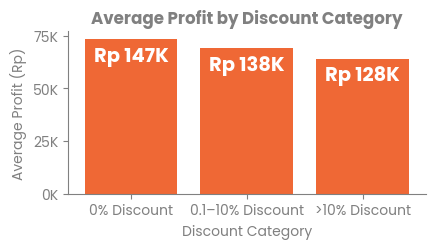

In [ ]:
df['discount_category'] = pd.cut(df['discount_percentage'], bins=[-0.01, 0.001, 0.10, 1], labels=['0% Discount', '0.1–10% Discount', '>10% Discount'])
avg_profit_per_category = df.groupby('discount_category')['nett_profit'].mean()

plt.figure(figsize=(4.5, 2.6))
plt.title('', fontsize=16, fontweight='bold')
colors = ['#ef6835', '#ef6835', '#ef6835']

bars = plt.bar(avg_profit_per_category.index, avg_profit_per_category.values, color=colors, linewidth=1.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_yticklabels([f'{int(y/1000)}K' for y in plt.gca().get_yticks()])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - (height * 0.05), f'Rp {height/1000:,.0f}K', ha='center', va='top', fontsize=14, fontweight='bold', color='white')

plt.title('Average Profit by Discount Category')
plt.ylabel('Average Profit (Rp)')
plt.xlabel('Discount Category')

plt.tight_layout()
plt.show()

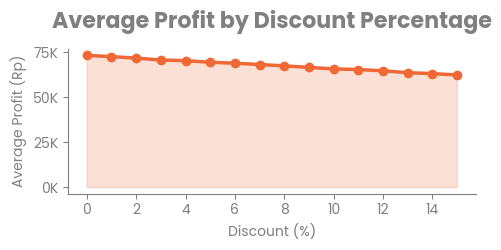

In [ ]:
profit_by_discount = df.groupby('discount_percentage')['nett_profit'].mean()

plt.figure(figsize=(5, 2.6))
plt.plot(profit_by_discount.index * 100, profit_by_discount.values, marker='o', linewidth=2.5, markersize=6, color='#ef6835')
plt.fill_between(profit_by_discount.index * 100, profit_by_discount.values, alpha=0.2, color='#ef6835')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([f'{int(y/1000)}K' for y in ax.get_yticks()])

plt.title('Average Profit by Discount Percentage', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Discount (%)')
plt.ylabel('Average Profit (Rp)')

plt.tight_layout()
plt.show()

### **Discount Effectiveness Analysis**

* **Financial Impact**
    - Profit Decline: -14.8%
    - Loss per transaction: Rp 21,750

* **Customer Satisfaction**
    - Rating: 4.0 (constant across all discount levels)
    - No improvement from 0% to 15% discount

* **Transaction Volume**
    - Stable at ~44K transactions
    - No volume increase from discounting

**Profit by Discount Category**
- **0% Discount**: Rp 147K avg profit
- **0.1-10% Discount**: Rp 138K avg profit
- **>10% Discount**: Rp 128K avg profit

**Critical Finding**

Discounts are ineffective. Analysis reveals:
- Customer ratings remain constant at 4.0 across all discount levels (0%-15%)
- Profit drops 14.8% from 0% to 15% discounts
- Near-zero correlation between discounts and satisfaction
- Data proves discounts erode margins without customer or volume benefits

**Recommended Actions**

1. **Cease Mass Discounting**: Discounting fails to improve satisfaction or drive volume

2. **Enhance Patient Care**: Uphold 4.0 rating via superior clinical service & counseling instead of price cuts

3. **Implement Patient Programs**: Replace discounts with targeted health & adherence strategies that build real loyalty

**Strategic Insight**

Current 4.0 rating is maintained regardless of discount level, suggesting customers value service quality over price reductions. Shift investment from margin-eroding discounts to value-adding patient care initiatives.

## **Transaction Rating Analysis**

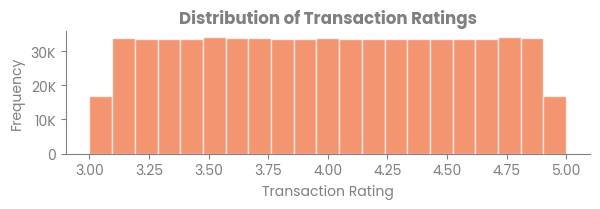

In [ ]:
# Distribution of Transaction Ratings
plt.figure(figsize=(6.1, 2.2))
plt.hist(df['rating_transaksi'], bins=21, color='#ef6835', edgecolor='white', alpha=0.7)

plt.title('Distribution of Transaction Ratings')
plt.xlabel('Transaction Rating')
plt.ylabel('Frequency')

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

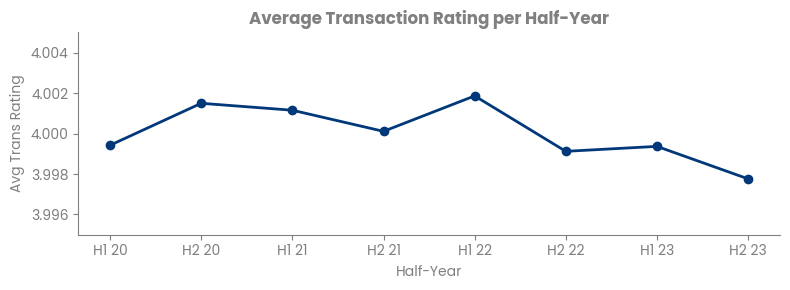

In [ ]:
# Average Transaction Rating per Half-Year
df['half_year'] = df['date'].apply(lambda x: f"H{1 if x.month <= 6 else 2} {str(x.year)[-2:]}")

rating_per_half = (df.groupby('half_year')['rating_transaksi'].mean().reset_index())
rating_per_half['year'] = rating_per_half['half_year'].apply(lambda x: int('20' + x.split(' ')[1]))
rating_per_half['half'] = rating_per_half['half_year'].apply(lambda x: int(x[1]))
rating_per_half = rating_per_half.sort_values(by=['year', 'half'])

plt.figure(figsize=(8, 3))
plt.plot(rating_per_half['half_year'], rating_per_half['rating_transaksi'], marker='o', linewidth=2, color='#003879')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Average Transaction Rating per Half-Year')
plt.xlabel('Half-Year')
plt.ylabel('Avg Trans Rating')
plt.ylim(3.995, 4.005)

plt.tight_layout()
plt.show()

### **Rating System Analysis: Fixing Our Broken System**

**Current System Problems**: No improvement in 4 years
- Avg rating flat at ~4.00 from H1 2020 to H2 2023
- Minimal variance despite market changes

**Business Impact**: Ratings don't affect sales behavior
- Zero correlation between ratings and business outcomes
- Unchanging 4.0 score provides no actionable insights

**Feedback Value**: Identical scores across all dimensions
- Extreme uniformity (provincial variance only 0.02 points)
- All dimensions cluster around 4.0
- Distribution shows narrow range (3.00-5.00) with peak at 4.00

**Root Cause Analysis**

Extreme uniformity (all dimensions score 4.0, provincial variance only 0.02 points) indicates the rating system is either insensitive or customers are disengaged. Combined with zero correlation to business metrics, this suggests the rating system needs a complete overhaul to become an actionable business intelligence tool.

**Strategic Solutions**

1. **Redesign Rating System**: Add clinical dimensions for actionable feedback
    - Include counseling clarity, medication explanation quality
    - Create specific, measurable service attributes
    - Move beyond generic satisfaction scores

2. **Real-time Feedback Loop**: Implement post-transaction survey
    - Deploy SMS/app survey immediately after transaction
    - Capture sentiment while experience is fresh
    - Enable rapid response to negative feedback

3. **Investigate Root Cause**: Analyze why ratings have zero impact
- Link feedback mechanisms to clinical quality goals
- Identify disconnect between ratings and operations
- Transform ratings into performance improvement tool

**Technical Note**

Current distribution shows excessive clustering at 4.0 with negligible variance, indicating systematic measurement failure rather than actual uniform satisfaction.